# Machine Learning 2021 Final Project
## Human Activity Recognition
### Oliver Wandschneider

#### Dataset
The dataset used consists of accelerometer and gyroscope data that was collected using a waist mounted smartphone. It can be downloaded [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip) but it is also possible to let it download automatically. This happens when the ``dataset/`` directory doesn't exist upon execution.

In [1]:
import io
import os
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sn
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import classification_report
from tensorflow.keras import layers

np.set_printoptions(precision=3, suppress=True)

#
# Download the dataset directly.
#
if not os.path.isdir("dataset"):
    req = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip")
    if req.ok:
        zipped = zipfile.ZipFile(io.BytesIO(req.content))
        zipped.extractall("dataset")
    else:
        print("Could not download the data. Add it manually.")


#### Loading the data
First of all the dataset is loaded. Both the train and the test data and their corresponding labels loaded as a 2-D array.

In [2]:
#
# Load the csv data.
#
def load_data_arrays(feature_remove=None):
    data_path = "dataset"
    train_x_df = pd.read_csv(os.path.join(data_path, "Train/X_train.txt"), delimiter=" ", header=None)
    train_y_df = pd.read_csv(os.path.join(data_path, "Train/y_train.txt"), delimiter=" ", header=None)

    test_x_df = pd.read_csv(os.path.join(data_path, "Test/X_test.txt"), delimiter=" ", header=None)
    test_y_df = pd.read_csv(os.path.join(data_path, "Test/y_test.txt"), delimiter=" ", header=None)

    if feature_remove:
        for inx in feature_remove:
            del train_x_df[inx]
            del test_x_df[inx]

    features = train_x_df.copy().to_numpy()
    labels = train_y_df.copy().to_numpy()

    test_features = test_x_df.copy().to_numpy()
    test_labels = test_y_df.copy().to_numpy()

    return features, labels, test_features, test_labels


feat, label, t_feat, t_label = load_data_arrays()


[1722, 1544, 1407, 1801, 1979, 1958, 70, 33, 107, 85, 139, 84]


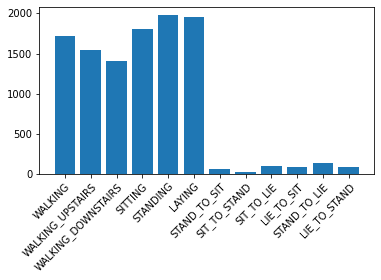

<Figure size 1152x720 with 0 Axes>

In [3]:
#
# Plots the distribution according to the number of occurences per label.
#
def plot_data_distribution(labels_1, label_2):
    total = labels_1.reshape(-1).tolist()
    total.extend(label_2.reshape(-1).tolist())
    bins = sorted(list(set(total)))

    plt.bar(bins, [total.count(bin_val) for bin_val in bins])
    print([total.count(bin_val) for bin_val in bins])
    plt.xticks(bins,
               ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING",
                "STAND_TO_SIT", "SIT_TO_STAND", "SIT_TO_LIE", "LIE_TO_SIT", "STAND_TO_LIE", "LIE_TO_STAND"],
               rotation=45,
               rotation_mode="anchor",
               ha="right")

    plt.subplots_adjust(bottom=0.3)
    plt.figure(figsize=(16, 10))
    plt.show()


plot_data_distribution(label, t_label)


#### Splitting the dataset
Because the label distribution is very unbalanced, I will handle the activities (labels 1-6) and the transitions (labels 7-12) individually.

The following method is used to split the data into the activity and transition part.

In [4]:
#
# Function to split the data into two parts
# (activities = labels 1 to 6, transitions = labels 7 to 12)
#
def split_data_by_labels(feat_arr: np.array, label_arr: np.array, first_indices: list):
    part_one_feat = list()
    part_one_label = list()
    part_two_feat = list()
    part_two_label = list()

    for inx, lbl in enumerate(label_arr):
        if lbl[0] in first_indices:
            part_one_label.append(lbl[0])
            part_one_feat.append(feat_arr[inx])
        else:
            part_two_label.append(lbl[0])
            part_two_feat.append(feat_arr[inx])

    return np.asarray(part_one_feat), np.asarray(part_one_label), np.asarray(part_two_feat), np.asarray(part_two_label)


#
# Split the test data into activities and transitions.
#
train_feat, train_lab, trans_feat, trans_lab = split_data_by_labels(feat, label, [1, 2, 3, 4, 5, 6])
test_feat, test_lab, test_trans_feat, test_trans_lab = split_data_by_labels(t_feat, t_label, [1, 2, 3, 4, 5, 6])


In [5]:
#
# Creates a one hot encoded vector of a label.
#
def create_one_hot(array, num_classes=6, offset=0):
    return np.eye(num_classes)[array - 1 - offset]


#
# Plots a confusion matrix of the given labels.
#
def plot_confusion_matrix(labels, pred, index, columns):
    conf = tf.math.confusion_matrix(labels=[np.argmax(val) for val in labels],
                                    predictions=[np.argmax(val) for val in pred])

    df_cm = pd.DataFrame(conf.numpy(), index=index, columns=columns)

    plt.figure(figsize=(10, 7))
    plt.tick_params(axis='both', which='major', labelsize=14, labelbottom=False, bottom=False, top=False,
                    labeltop=True)
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.show()


#### Activity Model
The activity model contains an input layer of size 561, a dense layer of size 228, another dense layer of size 232 and a softmax activated output layer of size 6 (for 6 possible labels). In between the dense layers are also batch normalization layers.

Because this is a multilayer classification I use the Categorical Crossentropy as a loss function. The learning rate is 0.0001 and the model will train 25 epochs in total.

In [45]:
#
# Activities
#
enc_train_lab = create_one_hot(train_lab)
enc_test_lab = create_one_hot(test_lab)

activity_model = tf.keras.Sequential([
    layers.Dense(228, input_dim=train_feat.shape[1]),
    layers.BatchNormalization(),
    layers.Activation("sigmoid"),
    layers.Dense(232),
    layers.BatchNormalization(),
    layers.Activation("sigmoid"),
    layers.Dense(6, activation='softmax')
])

print(activity_model.summary())

activity_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=[tfa.metrics.f_scores.F1Score(6, "micro")],
                       optimizer=tf.optimizers.Adam(learning_rate=0.0001))

act_hist = activity_model.fit(train_feat, enc_train_lab,
                              epochs=25,
                              validation_data=(test_feat, enc_test_lab),
                              batch_size=64)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 228)               128136    
_________________________________________________________________
batch_normalization_40 (Batc (None, 228)               912       
_________________________________________________________________
activation_28 (Activation)   (None, 228)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 232)               53128     
_________________________________________________________________
batch_normalization_41 (Batc (None, 232)               928       
_________________________________________________________________
activation_29 (Activation)   (None, 232)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 6)               

#### Transition Model
The transition model contains an input layer of size 561 that is a batch normalization layer. Then a dense layer of size 108, a batch normalization layer, and a dropout layer with a dropout rate of 0.5 follows.
A drouput layer randomly sets an input to 0 with the frequency being the dropout rate and is supposed to overfitting.

This is repeated with the dense layer having only 72 nerons this time and the output is also 6 neuron dense layer with a softmax activation.

In [34]:
#
# Transitions
#
enc_trans_lab = create_one_hot(trans_lab, num_classes=6, offset=6)
enc_test_trans_lab = create_one_hot(test_trans_lab, num_classes=6, offset=6)

transition_model = tf.keras.Sequential([
    layers.BatchNormalization(input_dim=trans_feat.shape[1]),
    layers.Dense(108),
    layers.BatchNormalization(),
    layers.Activation("sigmoid"),
    layers.Dropout(.5),
    layers.Dense(72),
    layers.BatchNormalization(),
    layers.Activation("sigmoid"),
    layers.Dropout(.5),
    layers.Dense(6, activation='softmax')
])

print(transition_model.summary())

transition_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                         metrics=[tfa.metrics.f_scores.F1Score(6, "micro")],
                         optimizer=tf.optimizers.Adam(learning_rate=0.005))

trans_hist = transition_model.fit(trans_feat, enc_trans_lab,
                                  epochs=25,
                                  validation_data=(test_trans_feat, enc_test_trans_lab))


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_35 (Batc (None, 561)               2244      
_________________________________________________________________
dense_36 (Dense)             (None, 108)               60696     
_________________________________________________________________
batch_normalization_36 (Batc (None, 108)               432       
_________________________________________________________________
activation_24 (Activation)   (None, 108)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 108)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 72)                7848      
_________________________________________________________________
batch_normalization_37 (Batc (None, 72)              

### Model Evaluation
#### General
To decide if the learning rate is adequate I look at the plot of the loss over the epochs and evaluate them like this:
![](https://cs231n.github.io/assets/nn3/learningrates.jpeg)

Also for checking if the model over- or underfits I looked at the gap between training accuracy and validation accuracy as follows:
![](https://cs231n.github.io/assets/nn3/accuracies.jpeg)

Images: [(source)](https://cs231n.github.io/neural-networks-3/#baby)

Using a confusion matrix I plot the predicted and true labels that were assigned on the test data.

#### Activity Model Evaluation
The activity model works very well.
The learning rate seems fine and there is little overfit.
The resulting metrics are very good (f1-score = 0.95) especially considering that the highest achieved (according to the owner of [this](https://github.com/deadskull7/Human-Activity-Recognition-with-Neural-Network-using-Gyroscopic-and-Accelerometer-variables) repository) was 0.98 during fitting their model.

However, when looking at their final classification report, **my results are actually better** with $precision=0.96$, $recall=0.95$, $f_1{-}score=0.95$ of my model compared to their results $precision=0.95, $recall=0.94$, $f_1{-}score=0.94$. My model perfomed better by 0.1 across the board.

I also tested the model with a higher amount of epochs (100) but the results stayed the roughly same.

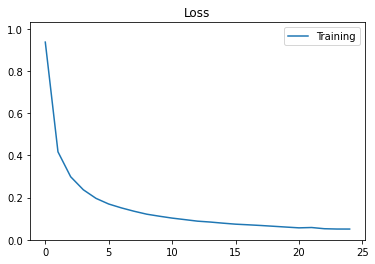

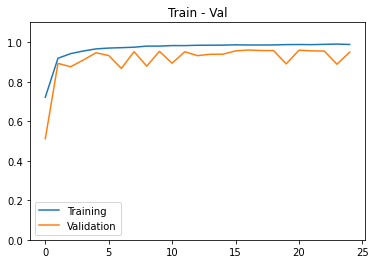

1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING


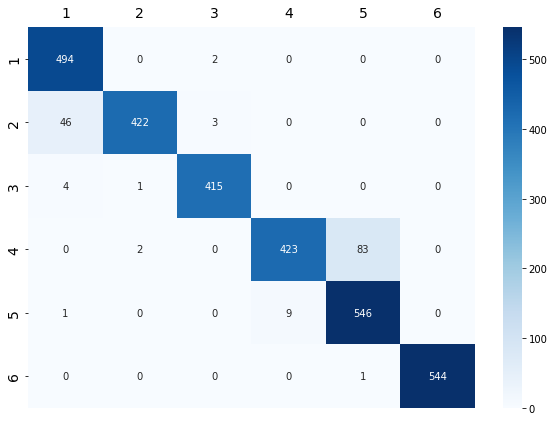

                    precision    recall  f1-score   support

           WALKING       0.91      1.00      0.95       496
  WALKING_UPSTAIRS       0.99      0.90      0.94       471
WALKING_DOWNSTAIRS       0.99      0.99      0.99       420
           SITTING       0.98      0.83      0.90       508
          STANDING       0.87      0.98      0.92       556
            LAYING       1.00      1.00      1.00       545

          accuracy                           0.95      2996
         macro avg       0.96      0.95      0.95      2996
      weighted avg       0.95      0.95      0.95      2996



In [47]:
plt.ylim((0, max(act_hist.history["loss"]) * 1.1))
plt.plot(act_hist.history["loss"], label="Training")
plt.title("Loss")
plt.legend()
plt.show()

plt.ylim((0, 1.1))
# The f1 score of tf is the same as categorical accuracy.
plt.plot(act_hist.history["f1_score"], label="Training")
plt.plot(act_hist.history["val_f1_score"], label="Validation")
plt.title("Train - Val")
plt.legend()
plt.show()

act_pred = activity_model.predict(test_feat)
act_classes = [i for i in range(1, 7)]

label_text = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
for inx, label in enumerate(label_text):
    print(inx + 1, label)

plot_confusion_matrix(labels=enc_test_lab,
                      pred=act_pred,
                      index=act_classes,
                      columns=act_classes)

print(classification_report(enc_test_lab.argmax(axis=1),
                            act_pred.argmax(axis=1),
                            target_names=label_text))

#### Transition Model Evaluation
The model performs worse as the activity model, which is to be expected as the amount of transition data is just a fraction of the *true* activity data.
The learning rate seems ok, but there is more overfitting than on the activity model.
The dropout layers do server their purpose of reducing overfitting which can be seen in the following plot, that shows the training and validation accuracy without the dropout layers.
![](img/tr_no_dropout.png)
Missclassifications almost never happen between transitions that are the reverse of each other (e.g. (7) stand-to-sit $\leftrightarrow$ (8) sit-to-stand), but rather between labels that share a part (e.g (9) sit-to-lie and (11) stand-to-lie).

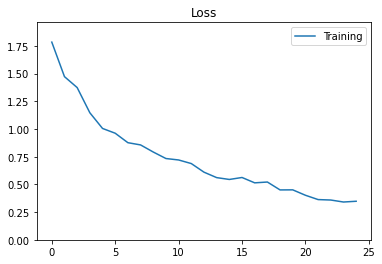

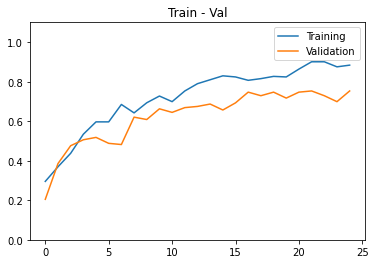

7 STAND_TO_SIT
8 SIT_TO_STAND
9 SIT_TO_LIE
10 LIE_TO_SIT
11 STAND_TO_LIE
12 LIE_TO_STAND


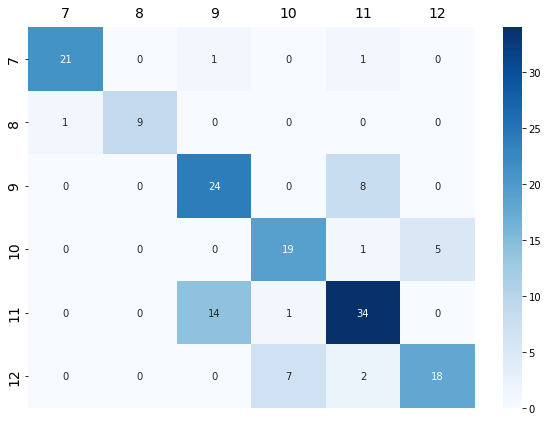

              precision    recall  f1-score   support

STAND_TO_SIT       0.95      0.91      0.93        23
SIT_TO_STAND       1.00      0.90      0.95        10
  SIT_TO_LIE       0.62      0.75      0.68        32
  LIE_TO_SIT       0.70      0.76      0.73        25
STAND_TO_LIE       0.74      0.69      0.72        49
LIE_TO_STAND       0.78      0.67      0.72        27

    accuracy                           0.75       166
   macro avg       0.80      0.78      0.79       166
weighted avg       0.76      0.75      0.76       166



In [48]:
plt.ylim((0, max(trans_hist.history["loss"]) * 1.1))
plt.plot(trans_hist.history["loss"], label="Training")
plt.title("Loss")
plt.legend()
plt.show()

plt.ylim((0, 1.1))
plt.plot(trans_hist.history["f1_score"], label="Training")
plt.plot(trans_hist.history["val_f1_score"], label="Validation")
plt.title("Train - Val")
plt.legend()
plt.show()

trans_pred = transition_model.predict(test_trans_feat)
trans_classes = [i for i in range(7, 13)]

label_text = ["STAND_TO_SIT", "SIT_TO_STAND", "SIT_TO_LIE", "LIE_TO_SIT", "STAND_TO_LIE", "LIE_TO_STAND"]
for inx, label in enumerate(label_text):
    print(inx + 7, label)

plot_confusion_matrix(labels=enc_test_trans_lab,
                      pred=trans_pred,
                      index=trans_classes,
                      columns=trans_classes)

print(classification_report(enc_test_trans_lab.argmax(axis=1) + 7,
                            trans_pred.argmax(axis=1) + 7,
                            target_names=label_text))
